# CambGB + RegPT

In [5]:

import os
z0 = 1.51
os.environ['z0']=str(z0)

#camb4GB
%cd ./cambGB
!sed -i '/transfer_redshift(1)/c transfer_redshift(1) = '$z0 ./planck18_params.ini
!~/camb4GB/camb ./planck18_params.ini
%cd ..


# RegPT
%cd ./camb_regpt
!camb ../cambGB/planck18_params.ini
!sed -i '1d' planck18_matterpower.dat
!~/RegPT/RegPT_11/RegPT.exe -spectrum -infile planck18_matterpower.dat -direct -nz 1 $z0 -pkfile p11.dat -datapath ~/RegPT/RegPT_11/data/
!~/RegPT/RegPT_12/RegPT.exe -spectrum -infile planck18_matterpower.dat -direct -nz 1 $z0 -pkfile p12.dat -datapath ~/RegPT/RegPT_12/data/
!~/RegPT/RegPT_22/RegPT.exe -spectrum -infile planck18_matterpower.dat -direct -nz 1 $z0 -pkfile p22.dat -datapath ~/RegPT/RegPT_22/data/
%cd ..

/home/littlelin/Cosmic/RSD/galaxy_spec/cambGB
Age of universe/GYr  =  13.797
Om_b h^2             =  0.022383
Om_c h^2             =  0.120107
Om_nu h^2            =  0.000645
Om_Lambda            =  0.684177
Om_K                 =  0.000000
Om_m (1-Om_K-Om_L)   =  0.315823
100 theta (CosmoMC)  =  1.040885
 1.00 nu, m_nu*c^2/k_B/T_nu0   =   356.53 (m_nu =  0.060 eV)
Reion opt depth      =  0.0000
tau_recomb/Mpc       =  280.71  tau_now/Mpc =  14149.9
   # of output Pk:           33
   ouput: k P_lin P_MC ...
 at z =    1.50999999      sigma8 (all matter)=  0.401445329    
    z =    1.50999999      f =   dlnD/dlna    =  0.932252944    
/home/littlelin/Cosmic/RSD/galaxy_spec
/home/littlelin/Cosmic/RSD/galaxy_spec/camb_regpt
Om_b h^2             =  0.022383
Om_c h^2             =  0.120108
Om_nu h^2            =  0.000645
Om_darkenergy        =  0.684097
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.315823
100 theta (CosmoMC)  =  1.040896
N_eff (total)        =  3.046000
 1 

In [6]:
%run read_pk.py

# TNS model

# Beulter

In [9]:
# %load TNS_Beutler.py
from astropy.cosmology import Planck15 as cosmo
from scipy import integrate
from scipy.special import legendre
import numpy as np

def pg_Beutler(u,k,z, 
       a_perp,a_para,fs8,b1s8,b2s8,s8,sv,Nshot):    
    
    f = fs8/s8
    
    dfog = np.exp(-(f*k*u*sv)**2)

    b1 = b1s8/s8 
    b2 = b2s8/s8
    
    bs2 = -4/7*(b1-1)
    b3nl = 32/315*(b1-1)
    
    pgdd = b1**2*pdd(k) + 2*b1*b2*pb2d(k) + 2*bs2*b1*pbs2d(k) + 2*b3nl*pb3nl(k) + b2**2*pb22(k)
 
    
    pgdv = b1*pdv(k) + b2*pb2v(k) + bs2*pbs2d(k) + b3nl*pb3nl(k)

    par1 = b1**3
    par2 = []
    for m,n in itertools.product(range(3),range(3)):
        if A[m,n] is not None:
            par2.append(u**(2*m)*(f/b1)**n*A[m,n](k))
    AA = par1*np.sum(par2,axis=0)

    par1 = b1**4
    par2 = []
    for m,a,b in itertools.product(range(4),range(2),range(2)):
        if B[m,a,b] is not None:
            par2.append(u**(2*m)*(-f/b1)**(a+b)*B[m,a,b](k))
    BB = par1*np.sum(par2,axis=0)
    
    pgz = dfog * (pgdd + 2*f*u**2*pgdv + f**2*u**4*pvv(k) + AA + BB)
    
    return pgz

def p_Beutler(l,k,z,
     a_perp,a_para,fs8,b1s8,b2s8,s8,sv,Nshot):   

    F = a_para/a_perp
    
    uu = np.linspace(-1,1,101)
    u = uu[1:]
    du = np.diff(uu)
    
    Ll = legendre(l)
    
    pp = []
    
   
    for i,ui in enumerate(u):
    
        k1 = k/a_perp*(1+ui**2*(1/F**2-1))**(1/2)
        u1 = ui/F*(1+ui**2*(1/F**2-1))**(-1/2)
    
        pgz =  pg_Beutler(u1,k1,z, 
           a_perp,a_para,fs8,b1s8,b2s8,s8,sv,Nshot)    
    
        
        pu = pgz*Ll(ui)
        pp.append(pu)

    pp = np.array(pp)
    pp = np.sum(pp*du[:,None],axis=0)
    
    pl = (2*l+1)/(2*a_para*a_perp**2) * pp
    
    if l==0:
        return pl+Nshot
    else:
        return pl

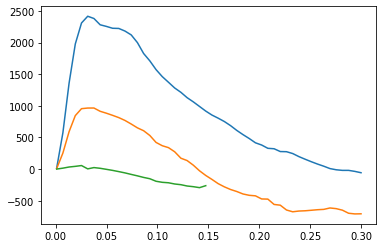

In [10]:
a_perp = 1.008
a_para = 1.001
fs8 = 0.478
b1s8 = 1.339
b2s8 = 1.16
Nshot = -1580
s8 = 0.345
sv = 6.80

z = z0
p0 = p_Beutler(0,kk,z,
         a_perp,a_para,fs8,b1s8,b2s8,s8,sv,Nshot) 

p2 = p_Beutler(2,kk,z,
         a_perp,a_para,fs8,b1s8,b2s8,s8,sv,Nshot) 
p4 = p_Beutler(4,kk,z,
         a_perp,a_para,fs8,b1s8,b2s8,s8,sv,Nshot) 

plt.plot(kk,kk*p0)
plt.plot(kk,kk*p2)
plt.plot(kk[:len(kk)//2],(kk*p4)[:len(kk)//2])

# Gongbo Zhao

In [11]:
# %load TNS_GB.py
from astropy.cosmology import Planck15 as cosmo
from scipy import integrate
from scipy.special import legendre


def pg(u,k,z, 
       zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot):    

    x = (cosmo.comoving_distance(z)/cosmo.comoving_distance(zp)).value-1
    
    az_perp = ap_perp + (ap_para-ap_perp)*x
    az_para = ap_para + 2*(ap_para-ap_perp)*x
    
    b1 = b1s8/s8 + 0.29*((1+z)**2-(1+zp)**2)
    b2 = b2s8/s8
    
    omega_ratio = ((1+z)/(1+zp))**3 * (az_para/ap_para)**2 * ((cosmo.H(zp)/cosmo.H(z)).value)**2
    fz = fps8/s8*omega_ratio**gamma

    
    vz = (cosmo.H(zp)/cosmo.H(z)).value * az_para/ap_para * (1+z)/(1+zp) * vp
    
    bs2 = -4/7*(b1-1)
    b3nl = 32/315*(b1-1)
    
    pgdd = b1**2*pdd(k) + 2*b1*b2*pb2d(k) + 2*bs2*b1*pbs2d(k) + 2*b3nl*pb3nl(k) + b2**2*pb22(k)
 
    
    
    pgdv = b1*pdv(k) + b2*pb2v(k) + bs2*pbs2d(k) + b3nl*pb3nl(k)

    dfog = (1+(k*u*vz)**2/2)**(-2)
    

    par1 = b1**3
    par2 = []
    for m,n in itertools.product(range(3),range(3)):
        if A[m,n] is not None:
            par2.append(u**(2*m)*(fz/b1)**n*A[m,n](k))
    AA = par1*np.sum(par2,axis=0)

    par1 = b1**4
    par2 = []
    for m,a,b in itertools.product(range(4),range(2),range(2)):
        if B[m,a,b] is not None:
            par2.append(u**(2*m)*(-fz/b1)**(a+b)*B[m,a,b](k))
    BB = par1*np.sum(par2,axis=0)
    
    pgz = dfog * (pgdd + 2*fz*u**2*pgdv + fz**2*u**4*pvv(k) + AA + BB)
    
    return pgz

    
def p(l,k,z,
     zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot):   

    x = (cosmo.comoving_distance(z)/cosmo.comoving_distance(zp)).value-1 
    az_perp = ap_perp + (ap_para-ap_perp)*x
    az_para = ap_para + 2*(ap_para-ap_perp)*x
    
    a = az_perp**(2/3)*az_para**(1/3)
    FAP = az_para/az_perp
    eps = FAP**(1/3)-1
    
    uu = np.linspace(-1,1,101)
    u = uu[1:]
    du = np.diff(uu)
    
    Ll = legendre(l)
    
    pp = []
    
    for i,ui in enumerate(u):
    
        k1 = k*(1+eps)/a*(1+ui**2*((1+eps)**(-6)-1))**(1/2)
        u1 = ui/(1+eps)**3*(1+ui**2*((1+eps)**(-6)-1))**(1/2)  
    
        pgz =  pg(u1,k1,z, 
           zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot)    
    
        
        pu = pgz*Ll(ui)
        pp.append(pu)

    pp = np.array(pp)
    pp = np.sum(pp*du[:,None],axis=0)
    
    pl = (2*l+1)/(2*az_para*az_perp**2) * pp
    
    if l==0:
        return pl+Nshot
    else:
        return pl


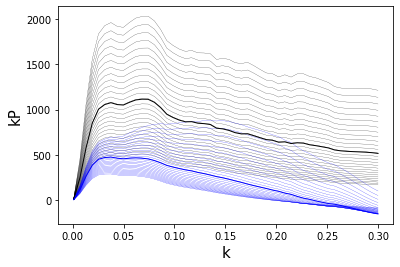

In [12]:
zp =  1.51         # zp
ap_perp = 1    # alpha_perp(zp)
ap_para = 1   # alpha_para(zp)
fps8 = 0.342         # f(zp)sigma8(zp)
gamma = 6/11        # gamma
b1s8 = 0.9         # b1(zp)sigma8(zp)
b2s8 = 0.7         # b2(zp)sigma8(zp)
s8 = 0.367            # sigma8(zp)
vp = 5.8           # sigma_v(zp) 
Nshot = 0

for z in np.concatenate([np.arange(0.825,2.175,0.05),np.array([1.52])]):
    z = round(z,3)
    p0 = p(0,kk,z,
             zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot) 

    p2 = p(2,kk,z,
             zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot) 
    p4 = p(4,kk,z,
             zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot) 

    lw=0.2
    if z==1.52:
        lw=1
    plt.plot(kk,kk*p0,c='k',lw=lw)
    plt.plot(kk,kk*p2,c='b',lw=lw)
#plt.plot(kk[:len(kk)//2],(kk*p4)[:len(kk)//2])
plt.xlabel(r'k',fontsize=15)
plt.ylabel(r'kP',fontsize=15)

theta0 = zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot